In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

 <h1> 4.  Machine Learning Models </h1>

In [2]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h3>4.1.1 Build sample train data from the train data</h3>

In [8]:
start = datetime.now()
#path = "sample/small/sample_train_sparse_matrix.npz"
path = "C:/Users/kyathi/Downloads/Netflix/train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=25000, no_movies=3000,
                                             path = path)

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:04.487155


In [9]:
sample_train_sparse_matrix = get_sample_sparse_matrix(sample_train_sparse_matrix, no_users=25000, no_movies=3000,
                                             path = path)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (25000 3000)
Sampled Matrix : Ratings -- 856986
Saving it into disk for furthur usage..
Done..



<h3>4.1.2 Build sample test data from the test data</h3>

In [13]:
start = datetime.now()

path = "C:/Users/kyathi/Downloads/Netflix/test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "C:/Users/kyathi/Downloads/Netflix/test_sparse_matrix.npz")
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:01.177137


In [16]:
 sample_test_sparse_matrix = get_sample_sparse_matrix(sample_test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "C:/Users/kyathi/Downloads/Netflix/sample_test_sparse_matrix.npz")

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..



<h2>4.2 Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [17]:
sample_train_averages = dict()

<h3>4.2.1 Finding Global Average of all movie ratings</h3>

In [18]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5875813607223455}

<h3> Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [20]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

<h3>4.2.2 Finding Average rating per User</h3>

In [21]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.923076923076923


<h3>4.2.3 Finding Average rating per Movie</h3>

In [22]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.752


<h2> 4.3 Featurizing data </h2>

<h4> 4.3.1.1 Featurizing train data </h4>

In [23]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [25]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('C:/Users/kyathi/Downloads/Netflix/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.001029


__Reading from the file to make a Train_dataframe__

In [26]:
reg_train = pd.read_csv('C:/Users/kyathi/Downloads/Netflix/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,174683,10,3.587581,5,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5
1,233949,10,3.587581,4,4.0,5.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,2.692308,3.611111,3
2,555770,10,3.587581,4,5.0,4.0,4.0,5.0,4.0,2.0,5.0,4.0,4.0,3.795455,3.611111,4
3,767518,10,3.587581,2,5.0,4.0,4.0,3.0,5.0,5.0,4.0,4.0,3.0,3.884615,3.611111,5
4,894393,10,3.587581,3,5.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,3.611111,4


<h4> 4.3.1.2 Featurizing test data </h4>

In [27]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [28]:
sample_train_averages['global']

3.5875813607223455

In [29]:
start = datetime.now()

if os.path.isfile('C:/Users/kyathi/Downloads/Netflix/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


__Reading from the file to make a test dataframe __

In [31]:
reg_test_df = pd.read_csv('C:/Users/kyathi/Downloads/Netflix/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


<h3> 4.3.2 Transforming data for Surprise models</h3>

In [32]:
from surprise import Reader, Dataset

In [33]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

<h4> 4.3.2.2 Transforming test data </h4>

In [35]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2> 4.4 Applying Machine Learning models </h2>

In [36]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [37]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

> __Utility functions for Surprise modes__

In [38]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h3> 4.4.1 XGBoost with initial 13 features </h3>

In [39]:
import xgboost as xgb

Training the model..
[12:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.


TEST DATA
------------------------------
RMSE :  1.081583007653566
MAPE :  35.961315162973335


<IPython.core.display.Javascript object>


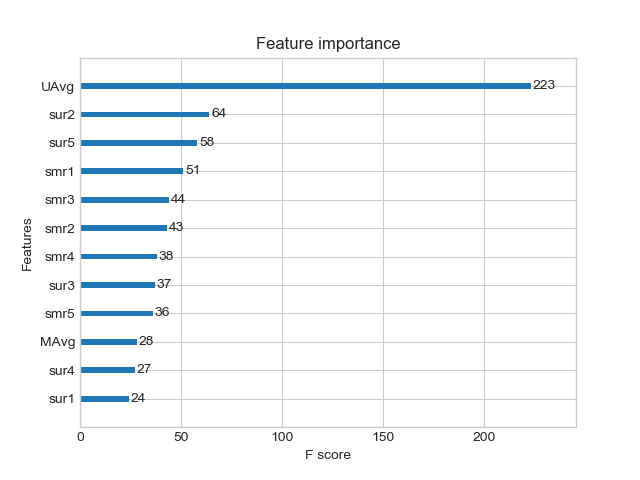

In [40]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

<h3> 4.4.2 Suprise BaselineModel </h3>
    


In [41]:
from surprise import BaselineOnly 

__Predicted_rating : ( baseline prediction ) __

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

__Optimization function ( Least Squares Problem ) __

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [43]:

# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.004982 

Evaluating the model with train data..
time taken : 0:00:00.005020
---------------
Train Data
---------------
RMSE : 1.1572922583391998

MAPE : 43.678235346644065

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.087793
---------------
Test Data
---------------
RMSE : 1.0766345330696123

MAPE : 34.76424320608691

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.099730


<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [44]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,174683,10,3.587581,5,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5,3.579379
1,233949,10,3.587581,4,4.0,5.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,2.692308,3.611111,3,3.539735


__Updating Test Data__

In [46]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.525727
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.525727


Training the model..
[12:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

<IPython.core.display.Javascript object>


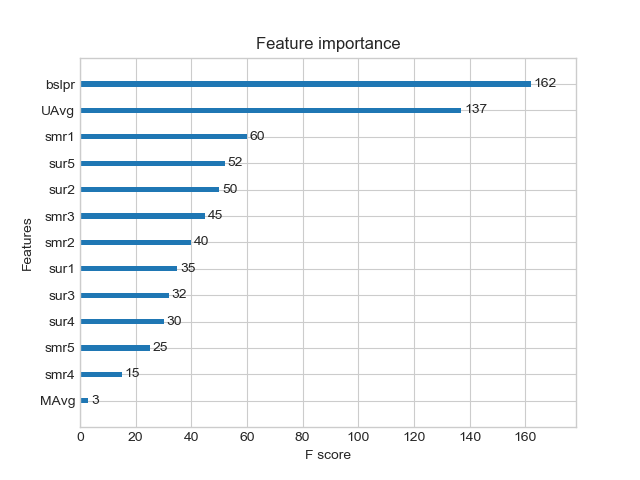

In [47]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

In [48]:
from surprise import KNNBaseline

  <h4> 4.4.4.1 Surprise KNNBaseline with user user similarities</h4>

In [49]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.019945 

Evaluating the model with train data..
time taken : 0:00:00.072807
---------------
Train Data
---------------
RMSE : 1.1064241367153657e-06

MAPE : 2.1149752643382073e-06

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.156311
---------------
Test Data
---------------
RMSE : 1.0764676907980537

MAPE : 34.75566778469752

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.250062


<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [50]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.001964 

Evaluating the model with train data..
time taken : 0:00:00.005984
---------------
Train Data
---------------
RMSE : 0.0005057080723780594

MAPE : 0.0010763626973100968

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.113693
---------------
Test Data
---------------
RMSE : 1.0764676907980537

MAPE : 34.75566778469752

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.122639


<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

__Preparing Train data __

In [52]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,174683,10,3.587581,5,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,2.0,3.882353,3.611111,5,3.579379,5.0,5.0
1,233949,10,3.587581,4,4.0,5.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0,2.692308,3.611111,3,3.539735,3.0,3.0


__Preparing Test data  __

In [53]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.525727,3.525727,3.525727
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.525727,3.525727,3.525727


Training the model..
Done. Time taken : 0:00:00.049866

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0815106326593642
MAPE :  34.253955518632026


<IPython.core.display.Javascript object>


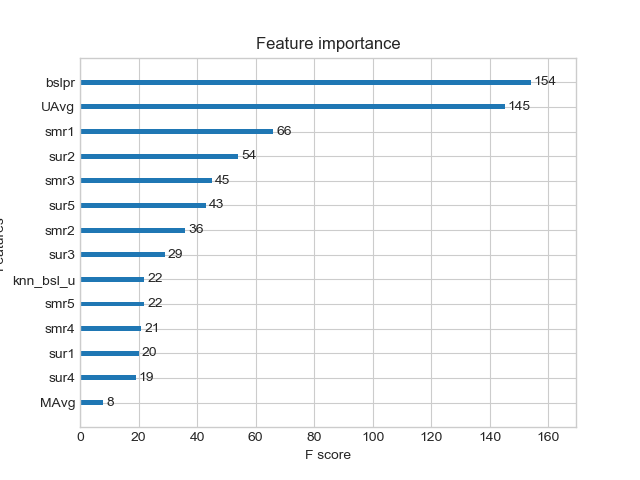

In [54]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

In [55]:
from surprise import SVD

In [56]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:00.083777 

Evaluating the model with train data..
time taken : 0:00:00.005984
---------------
Train Data
---------------
RMSE : 0.7982535625491375

MAPE : 30.00321224688236

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.088763
---------------
Test Data
---------------
RMSE : 1.0764800231592755

MAPE : 34.75643799062881

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.178524


  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [57]:
from surprise import SVDpp

In [58]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:00:00.073773 

Evaluating the model with train data..
time taken : 0:00:00.014959
---------------
Train Data
---------------
RMSE : 0.6516461313999461

MAPE : 24.106785618014374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.091753
---------------
Test Data
---------------
RMSE : 1.0764407122444284

MAPE : 34.754011711777984

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.180485


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [59]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.587581,5,5.0,3.0,4.0,4.0,3.0,5.0,...,3.0,2.0,3.882353,3.611111,5,3.579379,5.0,5.0,4.049197,3.978508
1,233949,10,3.587581,4,4.0,5.0,1.0,3.0,2.0,3.0,...,3.0,3.0,2.692308,3.611111,3,3.539735,3.0,3.0,3.386438,3.394440


__Preparing Test data  __

In [60]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.525727,3.525727,3.525727,3.525727,3.525727
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.525727,3.525727,3.525727,3.525727,3.525727


Training the model..
Done. Time taken : 0:00:00.054851

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1332509407099316
MAPE :  32.56685878592267


<IPython.core.display.Javascript object>


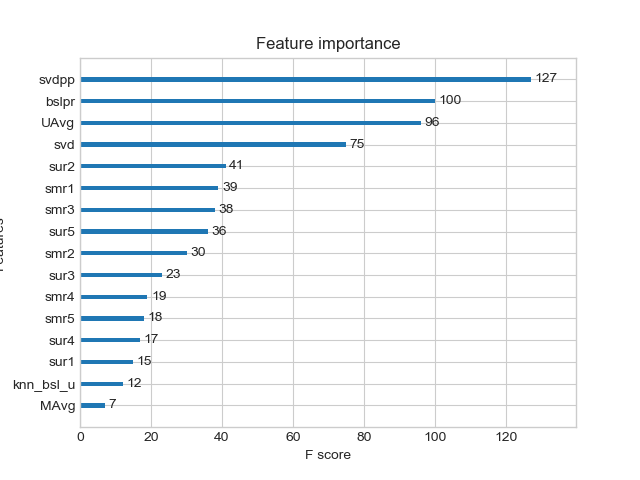

In [62]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

Training the model..
Done. Time taken : 0:00:00.037899

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0848689624526706
MAPE :  34.15939777958116


<IPython.core.display.Javascript object>


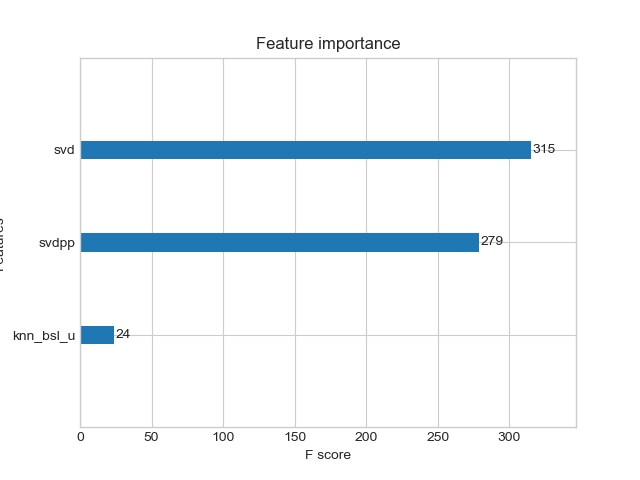

In [63]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

<h2> 4.5 Comparision between all models </h2>

In [64]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('C:/Users/kyathi/Downloads/Netflix/small_sample_results.csv')
models = pd.read_csv('C:/Users/kyathi/Downloads/Netflix/small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svdpp             1.0764407122444284
knn_bsl_u         1.0764676907980537
knn_bsl_m         1.0764676907980537
svd               1.0764800231592755
bsl_algo          1.0766345330696123
xgb_knn_bsl       1.0815106326593642
first_algo         1.081583007653566
xgb_all_models    1.0848689624526706
xgb_bsl           1.0935153383975023
xgb_final         1.1332509407099316
Name: rmse, dtype: object

<h3>Tuning hyperparameters of all xgboost models</h3>

In [67]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']


In [75]:
models_evaluation_trains = dict()
models_evaluation_tests = dict()

models_evaluation_trains, models_evaluation_tests

({}, {})

In [99]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}
first_xgb = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)
# store the results in models_evaluations dictionaries
models_evaluation_trains['first_algo'] = train_results
models_evaluation_tests['first_algo'] = test_results

Training the model..
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   11.0s finished


Done. Time taken : 0:00:12.045223

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.079583506049824
MAPE :  35.812555697025054


In [100]:
print(first_xgb.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [101]:
first_xgbs = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4,silent=1,subsample= 0.7, n_jobs=13, random_state=15)
first_xgbs.fit(x_train,
         y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=None, n_estimators=500,
       n_jobs=13, nthread=4, objective='reg:linear', random_state=15,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

<IPython.core.display.Javascript object>


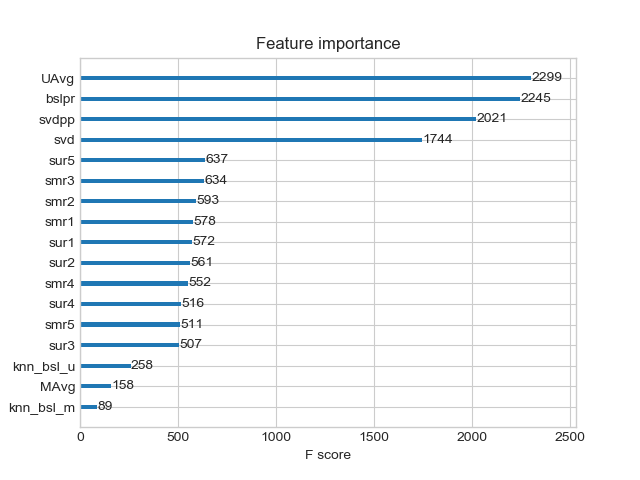

In [102]:
xgb.plot_importance(first_xgbs)
plt.show()

<h3> 4.4.2 Suprise BaselineModel </h3>
    


In [103]:
from surprise import BaselineOnly 

In [130]:

# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_trains['bsl_algo'] = bsl_train_results 
models_evaluation_tests['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.005369 

Evaluating the model with train data..
time taken : 0:00:00.007763
---------------
Train Data
---------------
RMSE : 1.1572922583391998

MAPE : 43.678235346644065

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.102798
---------------
Test Data
---------------
RMSE : 1.0766345330696123

MAPE : 34.76424320608691

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.116928


<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [131]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_trains['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.587581,5,5.0,3.0,4.0,4.0,3.0,5.0,...,3.0,2.0,3.882353,3.611111,5,3.579379,5.0,5.0,4.049197,3.978508
1,233949,10,3.587581,4,4.0,5.0,1.0,3.0,2.0,3.0,...,3.0,3.0,2.692308,3.611111,3,3.539735,3.0,3.0,3.386438,3.394440


__Updating Test Data__

In [132]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_tests['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.525727,3.525727,3.525727,3.525727,3.525727
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.525727,3.525727,3.525727,3.525727,3.525727


Training the model..
Done. Time taken : 0:00:00.433287

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0773701677037448
MAPE :  34.56726336323125


<IPython.core.display.Javascript object>


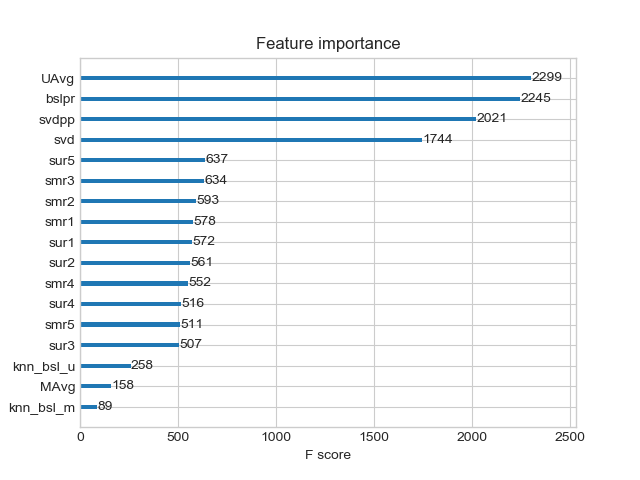

In [133]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4,silent=1,subsample= 0.7, n_jobs=13, random_state=15)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_trains['xgb_bsl'] = train_results
models_evaluation_tests['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

In [134]:
from surprise import KNNBaseline

  <h4> 4.4.4.1 Surprise KNNBaseline with user user similarities</h4>

In [135]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_trains['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_tests['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.026756 

Evaluating the model with train data..
time taken : 0:00:00.066316
---------------
Train Data
---------------
RMSE : 1.1064241367153657e-06

MAPE : 2.1149752643382073e-06

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.126891
---------------
Test Data
---------------
RMSE : 1.0764676907980537

MAPE : 34.75566778469752

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.220129


<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [136]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_trains['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_tests['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.004995 

Evaluating the model with train data..
time taken : 0:00:00.008933
---------------
Train Data
---------------
RMSE : 0.0005057080723780594

MAPE : 0.0010763626973100968

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.191844
---------------
Test Data
---------------
RMSE : 1.0764676907980537

MAPE : 34.75566778469752

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.205772


<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

__Preparing Train data __

In [137]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_trains['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_trains['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.587581,5,5.0,3.0,4.0,4.0,3.0,5.0,...,3.0,2.0,3.882353,3.611111,5,3.579379,5.0,5.0,4.049197,3.978508
1,233949,10,3.587581,4,4.0,5.0,1.0,3.0,2.0,3.0,...,3.0,3.0,2.692308,3.611111,3,3.539735,3.0,3.0,3.386438,3.394440


__Preparing Test data  __

In [138]:
reg_test_df['knn_bsl_u'] = models_evaluation_tests['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_tests['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.525727,3.525727,3.525727,3.525727,3.525727
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.525727,3.525727,3.525727,3.525727,3.525727


Training the model..
Done. Time taken : 0:00:00.435549

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0773701677037448
MAPE :  34.56726336323125


<IPython.core.display.Javascript object>


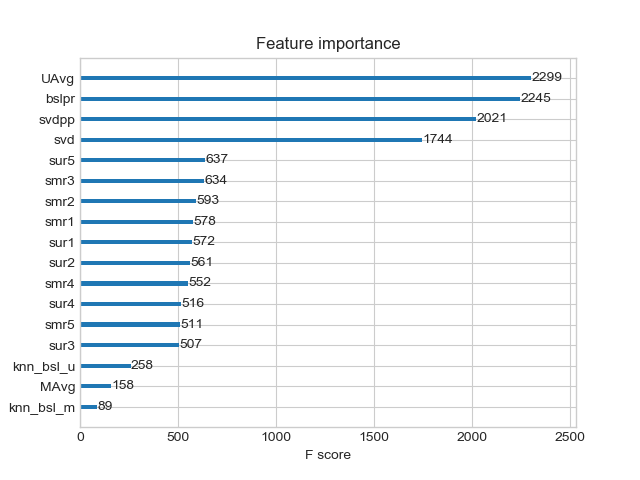

In [139]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4,silent=1,subsample= 0.7, n_jobs=13, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_trains['xgb_knn_bsl'] = train_results
models_evaluation_tests['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

In [140]:
from surprise import SVD

In [141]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_trains['svd'] = svd_train_results 
models_evaluation_tests['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:00.059511 

Evaluating the model with train data..
time taken : 0:00:00.007991
---------------
Train Data
---------------
RMSE : 0.7982535625491375

MAPE : 30.00321224688236

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.110904
---------------
Test Data
---------------
RMSE : 1.0764800231592755

MAPE : 34.75643799062881

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.178406


  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [142]:
from surprise import SVDpp

In [143]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_trains['svdpp'] = svdpp_train_results 
models_evaluation_tests['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:00:00.080034 

Evaluating the model with train data..
time taken : 0:00:00.020053
---------------
Train Data
---------------
RMSE : 0.6516461313999461

MAPE : 24.106785618014374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.125640
---------------
Test Data
---------------
RMSE : 1.0764407122444284

MAPE : 34.754011711777984

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.226632


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [144]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_trains['svd']['predictions']
reg_train['svdpp'] = models_evaluation_trains['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.587581,5,5.0,3.0,4.0,4.0,3.0,5.0,...,3.0,2.0,3.882353,3.611111,5,3.579379,5.0,5.0,4.049197,3.978508
1,233949,10,3.587581,4,4.0,5.0,1.0,3.0,2.0,3.0,...,3.0,3.0,2.692308,3.611111,3,3.539735,3.0,3.0,3.386438,3.394440


__Preparing Test data  __

In [145]:
reg_test_df['svd'] = models_evaluation_tests['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_tests['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.525727,3.525727,3.525727,3.525727,3.525727
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.525727,3.525727,3.525727,3.525727,3.525727


Training the model..
Done. Time taken : 0:00:00.450041

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0773701677037448
MAPE :  34.56726336323125


<IPython.core.display.Javascript object>


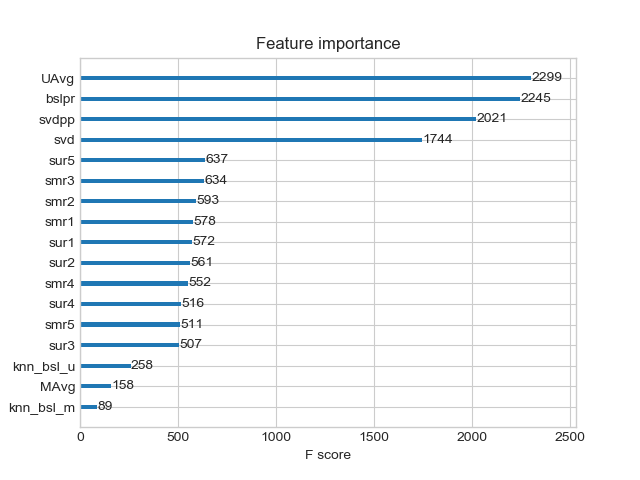

In [146]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4,silent=1,subsample= 0.7, n_jobs=13, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_trains['xgb_final'] = train_results
models_evaluation_tests['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

Training the model..
Done. Time taken : 0:00:00.219824

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.077284320176941
MAPE :  34.95545678737191


<IPython.core.display.Javascript object>


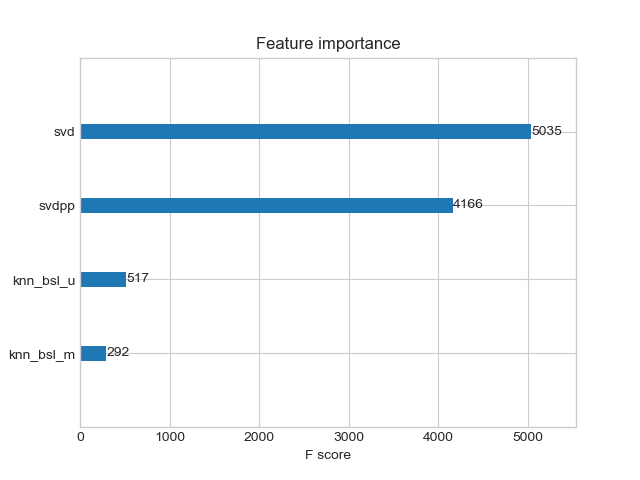

In [147]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4,silent=1,subsample= 0.7, n_jobs=13, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

<h2> 4.5 Comparision between all models </h2>

In [148]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_tests).to_csv('C:/Users/kyathi/Downloads/Netflix/tuned_sample_results.csv')
models = pd.read_csv('C:/Users/kyathi/Downloads/Netflix/tuned_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svdpp          1.0764407122444284
knn_bsl_u      1.0764676907980537
knn_bsl_m      1.0764676907980537
svd            1.0764800231592755
bsl_algo       1.0766345330696123
xgb_bsl        1.0773701677037448
xgb_knn_bsl    1.0773701677037448
xgb_final      1.0773701677037448
first_algo      1.079583506049824
Name: rmse, dtype: object

<h2>Observation:</h2>

__Taking 25K users and 3Kmoview__

In [5]:
#!/usr/bin/python3

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "RMSE"]
x.add_row(["svdpp",1.0764407122444284 ])
x.add_row(["knn_bsl_u",1.0764676907980537 ])
x.add_row(["knn_bsl_m",1.0764676907980537 ])
x.add_row(["svd", 1.0764800231592755])
x.add_row(["bsl_algo",1.0766345330696123 ])
x.add_row(["xgb_knn_bsl",1.0815106326593642 ])
x.add_row(["first_algo", 1.081583007653566])
x.add_row(["xgb_all_models", 1.0848689624526706])
x.add_row(["xgb_bsl", 1.0935153383975023])
x.add_row(["xgb_final", 1.1332509407099316])
print(x)

+----------------+--------------------+
|     Model      |        RMSE        |
+----------------+--------------------+
|     svdpp      | 1.0764407122444284 |
|   knn_bsl_u    | 1.0764676907980537 |
|   knn_bsl_m    | 1.0764676907980537 |
|      svd       | 1.0764800231592755 |
|    bsl_algo    | 1.0766345330696123 |
|  xgb_knn_bsl   | 1.0815106326593642 |
|   first_algo   | 1.081583007653566  |
| xgb_all_models | 1.0848689624526706 |
|    xgb_bsl     | 1.0935153383975023 |
|   xgb_final    | 1.1332509407099316 |
+----------------+--------------------+


__After hyperparameter tuning with 25k users and 3k movies__

In [7]:
x = PrettyTable()
x.field_names = ["Model", "RMSE"]
x.add_row(["svdpp",1.0764407122444284 ])
x.add_row(["knn_bsl_u", 1.0764676907980537])
x.add_row(["knn_bsl_m",1.0764676907980537 ])
x.add_row(["svd", 1.0764800231592755])
x.add_row(["bsl_algo", 1.0766345330696123])
x.add_row(["xgb_bsl", 1.0773701677037448])
x.add_row(["xgb_knn_bsl", 1.0773701677037448])
x.add_row(["xgb_final",1.0773701677037448 ])
x.add_row(["first_algo", 1.079583506049824])
print(x)

+-------------+--------------------+
|    Model    |        RMSE        |
+-------------+--------------------+
|    svdpp    | 1.0764407122444284 |
|  knn_bsl_u  | 1.0764676907980537 |
|  knn_bsl_m  | 1.0764676907980537 |
|     svd     | 1.0764800231592755 |
|   bsl_algo  | 1.0766345330696123 |
|   xgb_bsl   | 1.0773701677037448 |
| xgb_knn_bsl | 1.0773701677037448 |
|  xgb_final  | 1.0773701677037448 |
|  first_algo | 1.079583506049824  |
+-------------+--------------------+
